## operating cost 與 hk total recycling rate

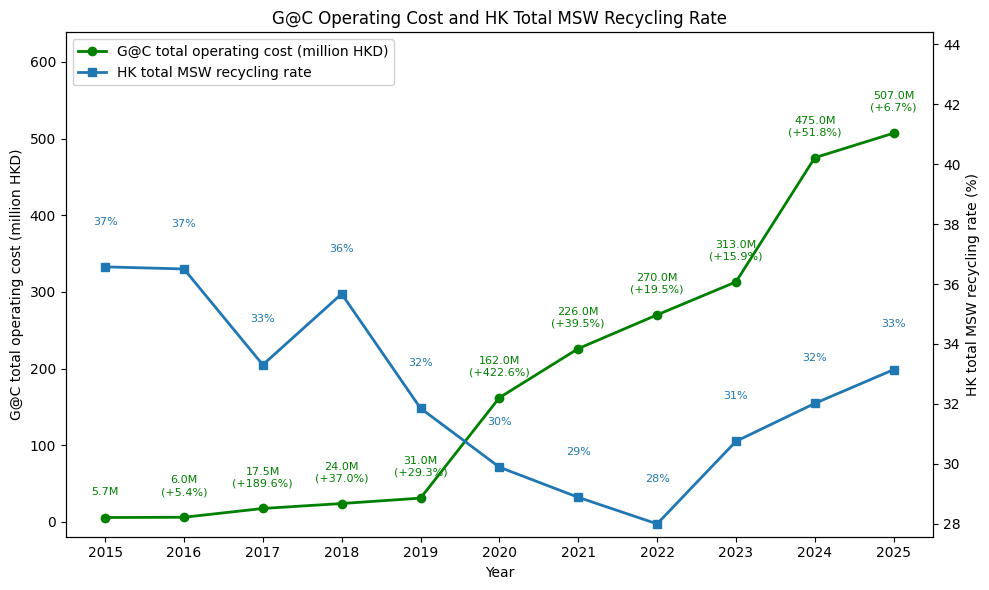

In [6]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys

def _ensure(pkg, mod=None):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("numpy")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path

# ---------- load data from the correct sheets ----------
data_path = Path("../General Stats_G@C_clean.xlsx")

# Sheet with operating cost
cost_df = pd.read_excel(
    data_path,
    sheet_name="G@C Recyclables Collection Volu",
    engine="openpyxl"
)

# Sheet with HK total MSW recycling rate
msw_df = pd.read_excel(
    data_path,
    sheet_name="HK MSW Volume and Recycling Rat",
    engine="openpyxl"
)

# ---------- select & clean the needed columns ----------

# 1. G@C total operating cost
col_cost = "G@C total operating cost"
cost_df = cost_df[["Year", col_cost]].dropna(subset=[col_cost]).copy()

# convert "5,730,000" -> 5730000.0
cost_df[col_cost] = pd.to_numeric(
    cost_df[col_cost].astype(str).str.replace(",", ""),
    errors="coerce"
)

# 2. HK total MSW recycling rate
col_rate = "HK total MSW recycling rate"
rate_raw = msw_df[col_rate].dropna()

# convert to numeric, handling either "40%" style or 0.40 style
rate_numeric = pd.to_numeric(
    rate_raw.astype(str).str.rstrip("%"),
    errors="coerce"
)
if rate_numeric.max() <= 1.0:
    # values are proportions (0.40), convert to percentages (40)
    rate_numeric = rate_numeric * 100.0

# Align lengths by taking the last N recycling-rate values,
# where N = number of operating-cost years
n = len(cost_df)
rate_aligned = rate_numeric.iloc[-n:].reset_index(drop=True)

# Attach the aligned recycling rates to the cost dataframe
cost_df = cost_df.iloc[-n:].reset_index(drop=True)
cost_df["recycling_rate_pct"] = rate_aligned

# Year-on-year % increase in G@C total operating cost
cost_df["cost_pct_change"] = cost_df[col_cost].pct_change() * 100

# X-axis labels: show only the starting year (e.g. "2015" from "2015-16")
x_labels = cost_df["Year"].astype(str).str[:4].tolist()
x = np.arange(len(cost_df))

# For nicer scale, plot cost in million HKD
cost_df["cost_million"] = cost_df[col_cost] / 1_000_000

# ---------- plotting ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Line 1: G@C total operating cost (green)
line1, = ax1.plot(
    x,
    cost_df["cost_million"],
    marker="o",
    linewidth=2,
    color="green",
    label="G@C total operating cost (million HKD)",
)
ax1.set_xlabel("Year")
ax1.set_ylabel("G@C total operating cost (million HKD)", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels, rotation=0)

# Add headroom so green labels don't hit the top
y1_min, y1_max = ax1.get_ylim()
ax1.set_ylim(y1_min, y1_max * 1.2)
y1_range = ax1.get_ylim()[1] - ax1.get_ylim()[0]
offset_cost = y1_range * 0.04  # vertical gap between marker and label

# Label each GREEN point with value and % increase
for xi, cost_m, pct in zip(x, cost_df["cost_million"], cost_df["cost_pct_change"]):
    if np.isnan(pct):
        label = f"{cost_m:.1f}M"
    else:
        label = f"{cost_m:.1f}M\n({pct:+.1f}%)"
    ax1.text(
        xi,
        cost_m + offset_cost,
        label,
        ha="center",
        va="bottom",
        fontsize=8,
        color="green",
    )

# Line 2: HK total MSW recycling rate (blue, in %)
ax2 = ax1.twinx()
line2, = ax2.plot(
    x,
    cost_df["recycling_rate_pct"],
    marker="s",
    linestyle="-",
    linewidth=2,
    color="tab:blue",
    label="HK total MSW recycling rate",
)
ax2.set_ylabel("HK total MSW recycling rate (%)", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Format right y-axis as whole numbers (28, 30, 32, ...)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Add headroom for blue labels
y2_min, y2_max = ax2.get_ylim()
ax2.set_ylim(y2_min, y2_max * 1.2)
y2_range = ax2.get_ylim()[1] - ax2.get_ylim()[0]

# Put blue labels a bit ABOVE the blue markers, with extra space
offset_rate = y2_range * 0.08

for xi, yi in zip(x, cost_df["recycling_rate_pct"]):
    ax2.text(
        xi,
        yi + offset_rate,
        f"{yi:.0f}%",
        ha="center",
        va="bottom",
        fontsize=8,
        color="tab:blue",
    )

# Legend in top-left
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(
    lines,
    labels,
    loc="upper left",
    frameon=True,
    fancybox=True,
    framealpha=0.9,
)

# Title and layout
plt.title(
    "G@C Operating Cost and HK Total MSW Recycling Rate"
)

fig.tight_layout()
plt.show()
